In [1]:
# Displays or modifies the intervals between automatic Notebook saves. The default setting is every 120 seconds.
%autosave 60
# Load all the import for every execution of a script.
%load_ext autoreload
%autoreload 2

Autosaving every 60 seconds


# Import

In [2]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
from shapely.geometry import mapping

If issue with cfgrib -->  pip install eccodes>=2.21.0

# Load data sets

In [3]:
path_data="../data/"

In [4]:
ndvi = xr.open_dataset(path_data+'NDVI/ndvi_01012010_09012022.nc')

In [5]:
era = xr.open_dataset(path_data+'meteo/adaptor.mars.internal-1663249407.7272627-22718-12-e830357e-7728-41cf-9b2b-b7f34cabf652.nc')

In [6]:
density = rxr.open_rasterio(path_data+"datasets/fra_pd_2015_1km_UNadj.tif",
                                 masked=True).squeeze()

In [7]:
density

<xarray.DataArray (y: 1171, x: 1766)>
[2067986 values with dtype=float32]
Coordinates:
    band         int32 1
  * x            (x) float64 -5.147 -5.139 -5.13 -5.122 ... 9.545 9.553 9.561
  * y            (y) float64 51.09 51.08 51.07 51.06 ... 41.36 41.35 41.35 41.34
    spatial_ref  int32 0
Attributes:
    STATISTICS_MAXIMUM:  53646.03515625
    STATISTICS_MEAN:     119.46772920052
    STATISTICS_MINIMUM:  0
    STATISTICS_STDDEV:   644.66432858711
    scale_factor:        1.0
    add_offset:          0.0

# Pre-process the datasets

## Setting the CRS for era data

In [13]:
import harmonize as hz

In [14]:
hz.print_crs(era)

None


In [15]:
hz.print_crs(ndvi)

None


In [16]:
# Era datasets is in WG84 or EPSG:4326
era = hz.define_crs(era, 4326)

In [18]:
hz.print_crs(era)

EPSG:4326


## Defining the Area Of Interest (aoi) 

In [19]:
aoi = hz.define_area_of_interest(path_data+"mygeodata.zip")
hz.print_crs_crop_extent(aoi)

epsg:4326


## Cliping to the AOI

### Era5 copernicus data

In [20]:
# Clipping the era data set to the aoi
era_clip = hz.clip_to_aoi(era,aoi)

### Density from worlpop

In [21]:
# Check the CRS of density dataset
hz.print_crs(density)

EPSG:4326


In [22]:
#Clipping the density dataset to the aoi
density_clip = hz.clip_to_aoi(density,aoi)

Quick plot to check-on

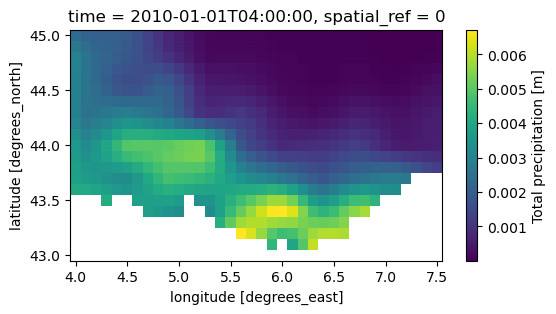

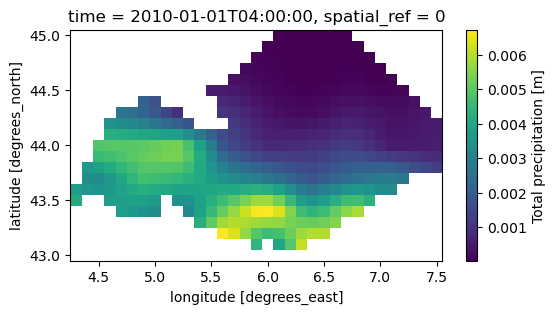

In [23]:
plt.figure(figsize=(6,3))
era['tp'][0].plot()
plt.figure(figsize=(6,3))
era_clip['tp'][0].plot()
plt.show()

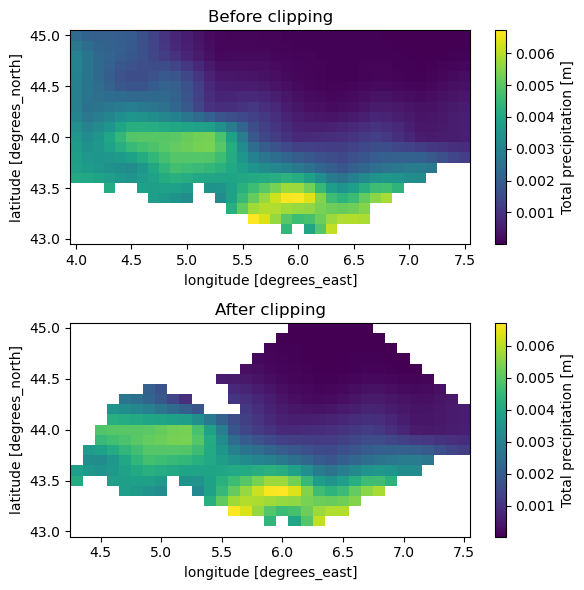

In [24]:
plt.rcParams["figure.figsize"] = [6, 6]
plt.rcParams["figure.autolayout"] = True

plt.subplot(2,1,1)
era['tp'][0].plot()
plt.title("Before clipping")

plt.subplot(2,1,2)
era_clip['tp'][0].plot()
plt.title("After clipping")

plt.show()

## Projection to the Lambert 93 (EPSG 2154)

In [25]:
era_clip_proj = hz.reproject_to_lambert93(era_clip)

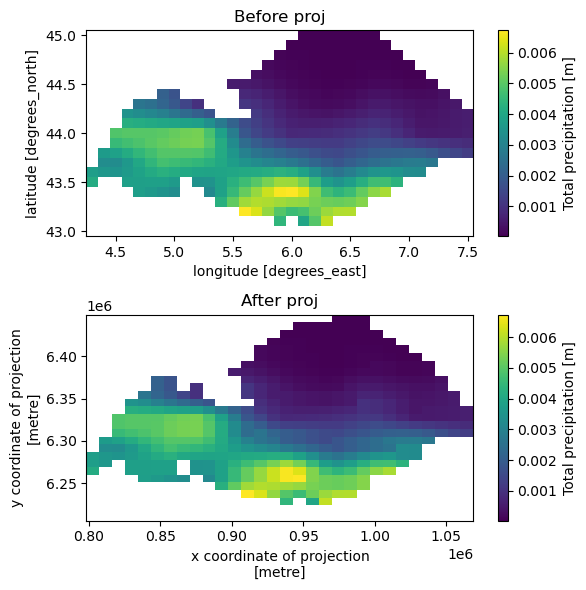

In [26]:
plt.rcParams["figure.figsize"] = [6, 6]
plt.rcParams["figure.autolayout"] = True

plt.subplot(2,1,1)
era_clip['tp'][0].plot()
plt.title("Before proj")

plt.subplot(2,1,2)
era_clip_proj['tp'][0].plot()
plt.title("After proj")



plt.show()

In [27]:
density_clip_proj = hz.reproject_to_lambert93(density_clip)

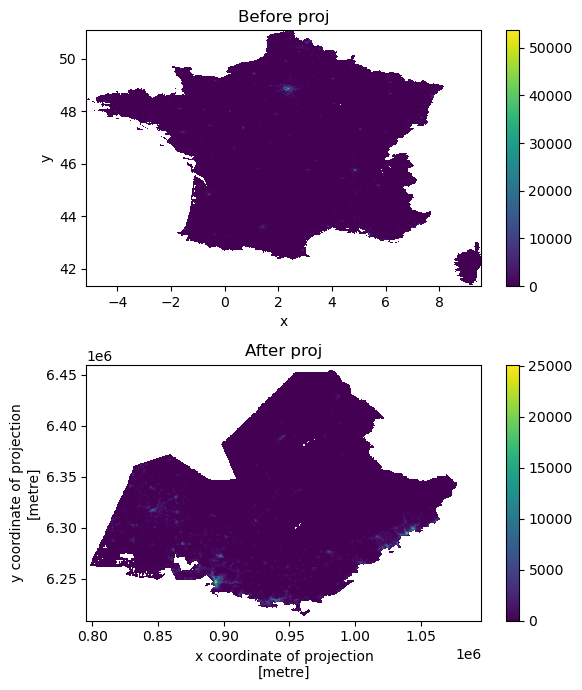

In [28]:
plt.rcParams["figure.figsize"] = [6, 7]
plt.rcParams["figure.autolayout"] = True

plt.subplot(2,1,1)
density.plot()
plt.title("Before proj")

plt.subplot(2,1,2)
density_clip_proj.plot()
plt.title("After proj")



plt.show()

In [29]:
print('Before process\n-------')
print(hz.print_raster(density))
print('After clip process\n-------')
print(hz.print_raster(density_clip))
print('After clip+projection process\n-------')
print(hz.print_raster(density_clip_proj))

Before process
-------
shape: (1171, 1766)
 resolution: (0.0083333333, -0.0083333333)
 bounds: (-5.151249979972164, 41.332916686736326, 9.565416627827837, 51.09124998103633)
 sum: 111435200.0
 CRS: EPSG:4326

After clip process
-------
shape: (259, 436)
 resolution: (0.0083333333, -0.008333333300000006)
 bounds: (4.215416649227837, 42.974583346836326, 7.848749968027837, 45.13291667153633)
 sum: 8798410.0
 CRS: EPSG:4326

After clip+projection process
-------
shape: (337, 404)
 resolution: (743.6792481464466, -743.6792481464466)
 bounds: (795543.0758350942, 6209260.592368431, 1095989.4920862585, 6459880.498993784)
 sum: 9792477.0
 CRS: EPSG:2154



## Regridding

Definition of a instance that will stand for the common grid to be shared.
The one from NDVI is already in 1km by 1km.


In [35]:
# definition of a common grid to interpolate from a dataset to another
common_grid = rxr.open_rasterio(path_data+"NDVI/ndvi_01012010_09012022.nc").isel(time=0)

In [ ]:
era_final = hz.interpolate_to_common_grid(era_clip_proj, common_grid)

In [ ]:
plt.rcParams["figure.figsize"] = [6, 6]
plt.rcParams["figure.autolayout"] = True

plt.subplot(2,1,1)
era_clip_proj['tp'][0].plot()
plt.title("After proj")


plt.subplot(2,1,2)
era_final['tp'][0].plot()
plt.title("After regridding")


plt.show()

In [146]:
print('After clip+projection process\n-------')
print_raster(era_final['tp'][0])

print('w/o projection to ndvi\n-------')
print_raster(era_clip_proj['tp'][0])

After clip+projection process
-------
shape: (259, 313)
resolution: (926.625433055556, -926.6254330555577)
bounds: (339144.9084983335, 4778607.358267501, 629178.6690447225, 5018603.345428891)
sum: 94.6980209350586
CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6371007.181,0]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]

w/o projection to ndvi
-------
shape: (27, 30)
resolution: (9019.728458017857, -9019.728458017857)
bounds: (798407.2145375567, 6205757.31861874, 1068999.0682780924, 6449289.9869852215)
sum: 1.0035686492919922
CRS: EPSG:2154



## Resample to one day

In [ ]:
ndvi_daily = hz.resample_to_daily(ndvi)

# Solution 1

We will save into a new data set the era dataset after its clipping and projection into lambert93. 
Then we will use the method open mfdataset to check what happen